In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip "/content/drive/MyDrive/giki-solar-energy-prediction-challenge.zip"

Archive:  /content/drive/MyDrive/giki-solar-energy-prediction-challenge.zip
  inflating: sample_submissions.csv  
  inflating: systems_new.csv         
  inflating: test_data_masked.csv    
  inflating: train_data.csv          


In [3]:
# %%
import pandas as pd
print("Loading datasets...")
systems_df = pd.read_csv('/content/systems_new.csv')
train_df = pd.read_csv('/content/train_data.csv')
test_df = pd.read_csv('/content/test_data_masked.csv')
sample_sub = pd.read_csv('/content/sample_submissions.csv')

train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])

train_df = train_df.sort_values(['system_id','timestamp'])
test_df = test_df.sort_values(['system_id','timestamp'])

print(f"✅ Train {train_df.shape}, Test {test_df.shape}")

Loading datasets...
✅ Train (3686726, 4), Test (938602, 5)


In [4]:
pip install pandas numpy matplotlib seaborn plotly scikit-learn scipy statsmodels

✅ Libraries imported successfully
Loading datasets...
✅ Systems data loaded: (109, 5)
✅ Training data loaded: (3686726, 4)
✅ Test data loaded: (938602, 5)
✅ Sample submission loaded: (98319, 5)
✅ Timestamps converted and data sorted
✅ Time features extracted
TRAINING DATA OVERVIEW
Date Range: 2023-08-01 11:00:00 to 2024-08-13 01:40:00
Total Records: 3,686,726
Unique Systems: 80
Data Frequency: 10 minutes
Total Days: 377

SYSTEM METADATA OVERVIEW
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   system_id        109 non-null    int64  
 1   connection_type  109 non-null    object 
 2   location         109 non-null    object 
 3   panels_capacity  109 non-null    float64
 4   load_capacity    109 non-null    float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.4+ KB
None

Connection Type Distribution:
connection_type
RESIDENTIA

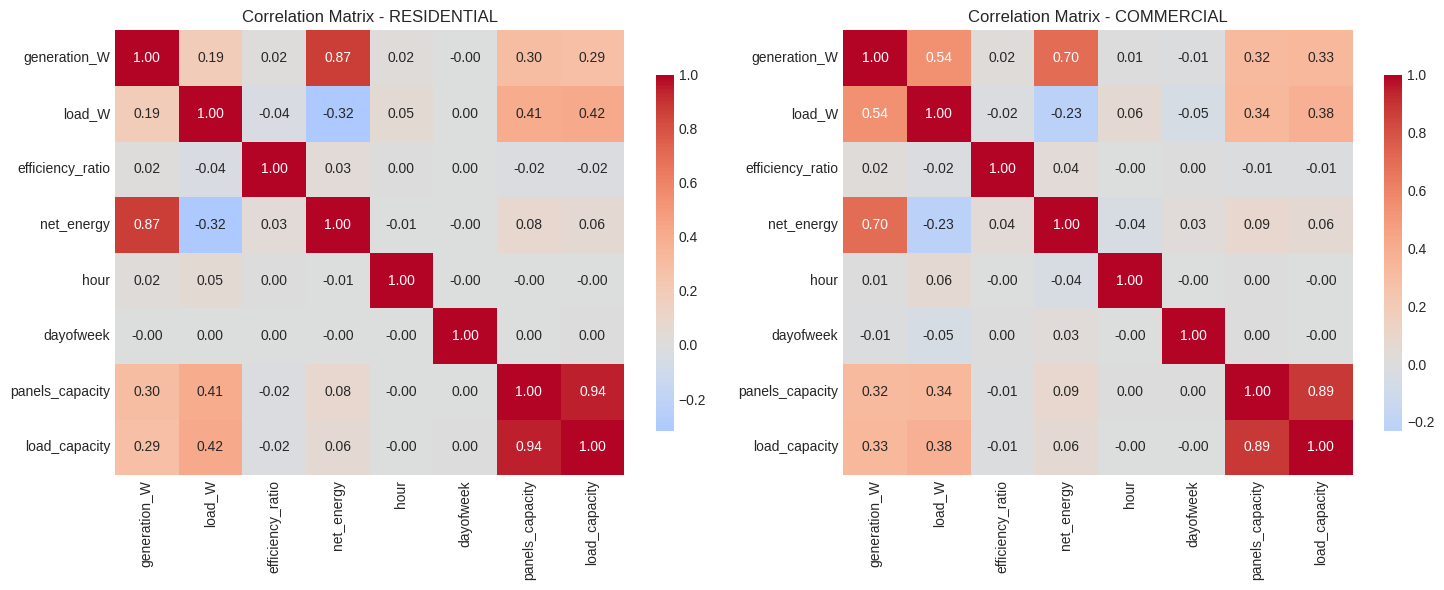

COMMERCIAL:
  Peak Generation Hour: 11:00
  Peak Load Hour: 11:00
  Hour Difference: 0 hours
RESIDENTIAL:
  Peak Generation Hour: 12:00
  Peak Load Hour: 14:00
  Hour Difference: 2 hours


DATA QUALITY ASSESSMENT

Missing Values in Training Data:
system_id       0
timestamp       0
generation_W    0
load_W          0
hour            0
day             0
month           0
dayofweek       0
quarter         0
is_weekend      0
hour_sin        0
hour_cos        0
month_sin       0
month_cos       0
dtype: int64

Negative Values Check (Training Data):
Negative Generation Values: 0
Negative Load Values: 0

Time Series Continuity Check:
System 3: 260 gaps detected
System 4: 186 gaps detected
System 5: 170 gaps detected
System 6: 159 gaps detected
System 7: 162 gaps detected


KEY INSIGHTS SUMMARY

📊 OVERALL METRICS:
Total Generation: 6.72 GW
Total Load: 6.07 GW
Overall Efficiency: 110.61%
Average Daily Generation: 18.25 MW
Average Daily Load: 16.50 MW

⚡ PEAK VALUES:
Maximum Generation: 52224.00 W
Maximum Load: 33771.97 W
Peak Generation Time: 2023-08-16 03:40:00
Peak Load Time: 2024-06-08 13:50:00

🏢 SYSTEM INSIGHTS:
Best Capacity Utilization: System 17 (1043.4%)
Location with Highest Avg Generation: FAISALABAD

⚠️ ANOMALY INSIGHTS:
Average Generation Anomaly Rate: 0.53%
Average Load Anomaly Rate: 2.72%
Systems with >5% Generation Anomalies: 3
Systems with >5% Load Anomalies: 17


Energy Balance Summary:
Net Exporters: 52 systems
Net Importers: 28 systems
Average Self-Sufficiency: 178.3%
PREDICTION READINESS ASSESSMENT

1 hour look-ahead:
  Total training sequences available: 3,686,246
  Average sequences per system: 46078

2 hours look-ahead:
  Total training sequences available: 3,685,766
  Average sequences per system: 46072

3 hours look-ahead:
  Total training sequences available: 3,685,286
  Average sequences per system: 46066

4 hours look-ahead:
  Total training sequences available: 3,684,806
  Average sequences per system: 46060
TEST DATA ANALYSIS
Total test records: 938,602
Records to predict (marked -1): 98,319 (10.5%)
Records beyond look-ahead (marked -2): 371,946 (39.6%)


RECOMMENDED FEATURES FOR PREDICTION MODEL

📈 TIME-BASED FEATURES:
  1. Hour of day (sin/cos encoded)
  2. Day of week
  3. Month (sin/cos encoded)
  4. Is weekend indicator
  5. Quarter of year
  6. Time since sunrise/sunset

📊 LAG FEATURES:
  1. Previous 1-6 time steps (10-60 min)
  2. Previous 12-24 time steps (2-4 hours)
  3. Same hour previous day
  4. Same hour previous week

📉 STATISTICAL FEATURES:
  1. Rolling mean (1hr, 2hr, 4hr windows)
  2. Rolling std deviation
  3. Rolling min/max
  4. Exponential weighted moving average

🏢 SYSTEM FEATURES:
  1. Panel capacity
  2. Load capacity
  3. Connection type (encoded)
  4. Location (encoded)
  5. Historical efficiency ratio
RECOMMENDED MODELING APPROACH

🔧 LSTM:
  Use Case: Primary model for complex pattern capture
  Pros: Captures long-term dependencies, Handles sequential patterns well, Good for multi-step forecasting
  Cons: Computationally expensive, Requires more data, Black box nature

🔧 XGBoost:
  Use Case: Quick baseline and

In [5]:
# %% [markdown]
# # 🌞 Solar Energy Generation & Load Consumption - Advanced EDA
#
# ## Project Overview
# Developing a predictive system for solar energy generation and load consumption using real-world PV system data.
# - **Objective**: Predict future PV power generation and load consumption at 10-minute intervals (1-4 hours ahead)
# - **Key Metric**: Energy efficiency = Generation ÷ Consumption ratio

# %% [markdown]
# ## 1. Environment Setup & Data Loading

# %%
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import calendar

# Configure display settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully")

# %% [markdown]
# ## 2. Data Loading & Initial Inspection

# %%
# Load all datasets
print("Loading datasets...")

# Load system metadata
systems_df = pd.read_csv('/content/systems_new.csv')
print(f"✅ Systems data loaded: {systems_df.shape}")

# Load training data
train_df = pd.read_csv('/content/train_data.csv')
print(f"✅ Training data loaded: {train_df.shape}")

# Load test data
test_df = pd.read_csv('/content/test_data_masked.csv')
print(f"✅ Test data loaded: {test_df.shape}")

# Load sample submission
sample_sub = pd.read_csv('/content/sample_submissions.csv')
print(f"✅ Sample submission loaded: {sample_sub.shape}")

# %% [markdown]
# ## 3. Data Preprocessing & Type Conversion

# %%
# Convert timestamp columns to datetime
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
sample_sub['timestamp'] = pd.to_datetime(sample_sub['timestamp'])

# Sort by system_id and timestamp
train_df = train_df.sort_values(['system_id', 'timestamp'])
test_df = test_df.sort_values(['system_id', 'timestamp'])

print("✅ Timestamps converted and data sorted")

# Extract time-based features
def extract_time_features(df):
    df['hour'] = df['timestamp'].dt.hour
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['quarter'] = df['timestamp'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    return df

train_df = extract_time_features(train_df)
test_df = extract_time_features(test_df)

print("✅ Time features extracted")

# %% [markdown]
# ## 4. Basic Data Overview

# %%
# Display basic information
print("=" * 80)
print("TRAINING DATA OVERVIEW")
print("=" * 80)
print(f"Date Range: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
print(f"Total Records: {len(train_df):,}")
print(f"Unique Systems: {train_df['system_id'].nunique()}")
print(f"Data Frequency: 10 minutes")
print(f"Total Days: {(train_df['timestamp'].max() - train_df['timestamp'].min()).days}")

print("\n" + "=" * 80)
print("SYSTEM METADATA OVERVIEW")
print("=" * 80)
print(systems_df.info())
print("\nConnection Type Distribution:")
print(systems_df['connection_type'].value_counts())
print("\nLocation Distribution:")
print(systems_df['location'].value_counts().head(10))

# %% [markdown]
# ## 5. Merge Data for Comprehensive Analysis

# %%
# Merge training data with system metadata
train_merged = train_df.merge(systems_df, on='system_id', how='left')

# Calculate efficiency ratio (handling division by zero)
train_merged['efficiency_ratio'] = np.where(
    train_merged['load_W'] > 0,
    train_merged['generation_W'] / train_merged['load_W'],
    0
)

# Calculate net energy (positive = excess generation, negative = deficit)
train_merged['net_energy'] = train_merged['generation_W'] - train_merged['load_W']

print(f"✅ Merged dataset shape: {train_merged.shape}")
print("\nFirst few rows of merged data:")
train_merged.head()

# %% [markdown]
# ## 6. Statistical Summary & Distribution Analysis

# %%
# Statistical summary by connection type
print("=" * 80)
print("STATISTICAL SUMMARY BY CONNECTION TYPE")
print("=" * 80)

for conn_type in train_merged['connection_type'].unique():
    subset = train_merged[train_merged['connection_type'] == conn_type]
    print(f"\n{conn_type}:")
    print(subset[['generation_W', 'load_W', 'efficiency_ratio']].describe())

# %% [markdown]
# ## 7. Advanced Visualizations - Time Series Patterns

# %%
# Create interactive time series plot for sample systems
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('Generation vs Load Over Time',
                    'Efficiency Ratio Over Time',
                    'Net Energy (Generation - Load)'),
    vertical_spacing=0.1,
    specs=[[{"secondary_y": False}],
           [{"secondary_y": False}],
           [{"secondary_y": False}]]
)

# Select a few representative systems
sample_systems = train_merged['system_id'].unique()[:3]
colors = px.colors.qualitative.Set1

for idx, sys_id in enumerate(sample_systems):
    sys_data = train_merged[train_merged['system_id'] == sys_id].iloc[:1000]  # First 1000 points for clarity

    # Generation vs Load
    fig.add_trace(
        go.Scatter(x=sys_data['timestamp'], y=sys_data['generation_W'],
                   name=f'System {sys_id} Gen', line=dict(color=colors[idx], dash='solid')),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=sys_data['timestamp'], y=sys_data['load_W'],
                   name=f'System {sys_id} Load', line=dict(color=colors[idx], dash='dash')),
        row=1, col=1
    )

    # Efficiency Ratio
    fig.add_trace(
        go.Scatter(x=sys_data['timestamp'], y=sys_data['efficiency_ratio'],
                   name=f'System {sys_id} Eff', line=dict(color=colors[idx])),
        row=2, col=1
    )

    # Net Energy
    fig.add_trace(
        go.Scatter(x=sys_data['timestamp'], y=sys_data['net_energy'],
                   name=f'System {sys_id} Net', line=dict(color=colors[idx]),
                   fill='tozeroy', fillcolor=f'rgba({idx*80},{idx*40},{255-idx*80},0.2)'),
        row=3, col=1
    )

fig.update_xaxes(title_text="Timestamp", row=3, col=1)
fig.update_yaxes(title_text="Power (W)", row=1, col=1)
fig.update_yaxes(title_text="Ratio", row=2, col=1)
fig.update_yaxes(title_text="Net Energy (W)", row=3, col=1)

fig.update_layout(height=900, title_text="Time Series Analysis - Sample Systems", showlegend=True)
fig.show()

# %% [markdown]
# ## 8. Daily & Hourly Pattern Analysis

# %%
# Create hourly aggregation for pattern analysis
hourly_patterns = train_merged.groupby(['hour', 'connection_type']).agg({
    'generation_W': ['mean', 'std', 'median'],
    'load_W': ['mean', 'std', 'median'],
    'efficiency_ratio': ['mean', 'std']
}).reset_index()

# Flatten column names
hourly_patterns.columns = ['_'.join(col).strip() if col[1] else col[0]
                           for col in hourly_patterns.columns.values]

# Create advanced hourly pattern visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Average Generation by Hour', 'Average Load by Hour',
                    'Generation Variability (CV)', 'Load Variability (CV)'),
    specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
           [{'type': 'scatter'}, {'type': 'scatter'}]]
)

for conn_type in hourly_patterns['connection_type'].unique():
    data = hourly_patterns[hourly_patterns['connection_type'] == conn_type]

    # Calculate coefficient of variation
    gen_cv = data['generation_W_std'] / (data['generation_W_mean'] + 1e-6)
    load_cv = data['load_W_std'] / (data['load_W_mean'] + 1e-6)

    # Generation pattern
    fig.add_trace(
        go.Scatter(x=data['hour'], y=data['generation_W_mean'],
                   name=f'{conn_type} Gen', mode='lines+markers'),
        row=1, col=1
    )

    # Load pattern
    fig.add_trace(
        go.Scatter(x=data['hour'], y=data['load_W_mean'],
                   name=f'{conn_type} Load', mode='lines+markers'),
        row=1, col=2
    )

    # Generation variability
    fig.add_trace(
        go.Scatter(x=data['hour'], y=gen_cv,
                   name=f'{conn_type} Gen CV', mode='lines+markers'),
        row=2, col=1
    )

    # Load variability
    fig.add_trace(
        go.Scatter(x=data['hour'], y=load_cv,
                   name=f'{conn_type} Load CV', mode='lines+markers'),
        row=2, col=2
    )

fig.update_xaxes(title_text="Hour of Day")
fig.update_yaxes(title_text="Power (W)", row=1, col=1)
fig.update_yaxes(title_text="Power (W)", row=1, col=2)
fig.update_yaxes(title_text="CV", row=2, col=1)
fig.update_yaxes(title_text="CV", row=2, col=2)

fig.update_layout(height=700, title_text="Daily Pattern Analysis by Connection Type")
fig.show()

# %% [markdown]
# ## 9. Location-Based Analysis

# %%
# Aggregate by location
location_stats = train_merged.groupby('location').agg({
    'generation_W': ['mean', 'max', 'sum'],
    'load_W': ['mean', 'max', 'sum'],
    'efficiency_ratio': 'mean',
    'system_id': 'nunique'
}).reset_index()

location_stats.columns = ['_'.join(col).strip() if col[1] else col[0]
                          for col in location_stats.columns.values]
location_stats.columns = location_stats.columns.str.replace('system_id_nunique', 'num_systems')

# Create location comparison visualization
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Average Generation by City', 'Average Load by City',
                    'Average Efficiency Ratio', 'Total Energy Production'),
    specs=[[{'type': 'bar'}, {'type': 'bar'}],
           [{'type': 'bar'}, {'type': 'scatter'}]]
)

# Sort by generation for better visualization
location_stats_sorted = location_stats.sort_values('generation_W_mean', ascending=False).head(15)

fig.add_trace(
    go.Bar(x=location_stats_sorted['location'], y=location_stats_sorted['generation_W_mean'],
           name='Avg Generation', marker_color='gold'),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=location_stats_sorted['location'], y=location_stats_sorted['load_W_mean'],
           name='Avg Load', marker_color='coral'),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=location_stats_sorted['location'], y=location_stats_sorted['efficiency_ratio_mean'],
           name='Efficiency', marker_color='lightgreen'),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(x=location_stats_sorted['generation_W_sum'],
               y=location_stats_sorted['load_W_sum'],
               mode='markers+text',
               text=location_stats_sorted['location'],
               textposition="top center",
               marker=dict(size=location_stats_sorted['num_systems']*5,
                          color=location_stats_sorted['efficiency_ratio_mean'],
                          colorscale='Viridis',
                          showscale=True),
               name='Cities'),
    row=2, col=2
)

fig.update_xaxes(tickangle=45)
fig.update_layout(height=800, title_text="Location-Based Performance Analysis", showlegend=False)
fig.show()

# %% [markdown]
# ## 10. Anomaly Detection

# %%
# Detect anomalies using statistical methods
def detect_anomalies(df, column, method='iqr', threshold=1.5):
    if method == 'iqr':
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        anomalies = (df[column] < lower_bound) | (df[column] > upper_bound)
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(df[column].fillna(0)))
        anomalies = z_scores > threshold
    return anomalies

# Detect anomalies for each system
anomaly_results = []
for sys_id in train_merged['system_id'].unique():
    sys_data = train_merged[train_merged['system_id'] == sys_id].copy()

    # Detect generation anomalies
    sys_data['gen_anomaly'] = detect_anomalies(sys_data, 'generation_W', method='iqr', threshold=3)
    sys_data['load_anomaly'] = detect_anomalies(sys_data, 'load_W', method='iqr', threshold=3)

    anomaly_results.append({
        'system_id': sys_id,
        'total_records': len(sys_data),
        'gen_anomalies': sys_data['gen_anomaly'].sum(),
        'load_anomalies': sys_data['load_anomaly'].sum(),
        'gen_anomaly_pct': (sys_data['gen_anomaly'].sum() / len(sys_data)) * 100,
        'load_anomaly_pct': (sys_data['load_anomaly'].sum() / len(sys_data)) * 100
    })

anomaly_df = pd.DataFrame(anomaly_results)
anomaly_df = anomaly_df.merge(systems_df[['system_id', 'connection_type', 'location']], on='system_id')

# Visualize anomaly distribution
fig = px.scatter(anomaly_df,
                 x='gen_anomaly_pct',
                 y='load_anomaly_pct',
                 color='connection_type',
                 size='total_records',
                 hover_data=['system_id', 'location'],
                 title='Anomaly Distribution Across Systems',
                 labels={'gen_anomaly_pct': 'Generation Anomaly %',
                        'load_anomaly_pct': 'Load Anomaly %'})
fig.show()

# %% [markdown]
# ## 11. Seasonal & Monthly Patterns

# %%
# Monthly aggregation
monthly_patterns = train_merged.groupby(['month', 'connection_type']).agg({
    'generation_W': ['mean', 'sum'],
    'load_W': ['mean', 'sum'],
    'efficiency_ratio': 'mean'
}).reset_index()

monthly_patterns.columns = ['_'.join(col).strip() if col[1] else col[0]
                            for col in monthly_patterns.columns.values]

# Create monthly pattern visualization
fig = go.Figure()

for conn_type in monthly_patterns['connection_type'].unique():
    data = monthly_patterns[monthly_patterns['connection_type'] == conn_type]

    fig.add_trace(go.Scatterpolar(
        r=data['generation_W_mean'],
        theta=[calendar.month_abbr[i] for i in data['month']],
        name=f'{conn_type} Generation',
        fill='toself',
        line=dict(width=2)
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, monthly_patterns['generation_W_mean'].max()]
        )),
    showlegend=True,
    title="Monthly Generation Patterns (Polar Plot)"
)
fig.show()

# %% [markdown]
# ## 12. Correlation Analysis

# %%
# Select numerical columns for correlation
corr_columns = ['generation_W', 'load_W', 'efficiency_ratio', 'net_energy',
                'hour', 'dayofweek', 'panels_capacity', 'load_capacity']

# Calculate correlation matrix for each connection type
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, conn_type in enumerate(train_merged['connection_type'].unique()):
    if idx >= 2:
        break
    subset = train_merged[train_merged['connection_type'] == conn_type][corr_columns]
    corr_matrix = subset.corr()

    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, ax=axes[idx], cbar_kws={'shrink': 0.8})
    axes[idx].set_title(f'Correlation Matrix - {conn_type}')

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 13. Peak Hours Analysis

# %%
# Identify peak generation and load hours
peak_analysis = train_merged.groupby(['hour', 'connection_type']).agg({
    'generation_W': 'mean',
    'load_W': 'mean'
}).reset_index()

# Find peak hours for each metric and connection type
for conn_type in peak_analysis['connection_type'].unique():
    subset = peak_analysis[peak_analysis['connection_type'] == conn_type]
    peak_gen_hour = subset.loc[subset['generation_W'].idxmax(), 'hour']
    peak_load_hour = subset.loc[subset['load_W'].idxmax(), 'hour']

    print(f"{conn_type}:")
    print(f"  Peak Generation Hour: {peak_gen_hour}:00")
    print(f"  Peak Load Hour: {peak_load_hour}:00")
    print(f"  Hour Difference: {abs(peak_gen_hour - peak_load_hour)} hours")

# Visualize peak patterns
fig = px.line(peak_analysis, x='hour', y='generation_W',
              color='connection_type',
              title='Hourly Generation Patterns',
              labels={'generation_W': 'Average Generation (W)', 'hour': 'Hour of Day'})

# Add vertical lines for peak hours
for conn_type in peak_analysis['connection_type'].unique():
    subset = peak_analysis[peak_analysis['connection_type'] == conn_type]
    peak_hour = subset.loc[subset['generation_W'].idxmax(), 'hour']
    fig.add_vline(x=peak_hour, line_dash="dash",
                  annotation_text=f"{conn_type} Peak",
                  opacity=0.5)

fig.show()

# %% [markdown]
# ## 14. System Capacity Utilization

# %%
# Calculate capacity utilization
capacity_util = train_merged.groupby('system_id').agg({
    'generation_W': ['mean', 'max'],
    'load_W': ['mean', 'max'],
    'panels_capacity': 'first',
    'load_capacity': 'first',
    'connection_type': 'first',
    'location': 'first'
}).reset_index()

capacity_util.columns = ['_'.join(col).strip() if col[1] else col[0]
                         for col in capacity_util.columns.values]

# Calculate utilization percentages
capacity_util['gen_utilization'] = (capacity_util['generation_W_max'] /
                                    (capacity_util['panels_capacity_first'] * 1000)) * 100
capacity_util['load_utilization'] = (capacity_util['load_W_max'] /
                                     (capacity_util['load_capacity_first'] * 1000)) * 100

# Visualize capacity utilization
fig = px.scatter(capacity_util,
                 x='gen_utilization',
                 y='load_utilization',
                 color='connection_type_first',
                 size='panels_capacity_first',
                 hover_data=['system_id', 'location_first'],
                 title='System Capacity Utilization Analysis',
                 labels={'gen_utilization': 'Generation Capacity Utilization (%)',
                        'load_utilization': 'Load Capacity Utilization (%)'},
                 range_x=[0, 120],
                 range_y=[0, 120])

# Add reference line
fig.add_shape(type="line",
              x0=0, y0=0, x1=120, y1=120,
              line=dict(color="gray", dash="dash", width=1))

fig.show()

# %% [markdown]
# ## 15. Weekend vs Weekday Analysis

# %%
# Compare weekend vs weekday patterns
weekend_analysis = train_merged.groupby(['hour', 'is_weekend', 'connection_type']).agg({
    'generation_W': 'mean',
    'load_W': 'mean',
    'efficiency_ratio': 'mean'
}).reset_index()

# Create comparison plots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Residential - Generation', 'Commercial - Generation',
                    'Residential - Load', 'Commercial - Load')
)

for idx, conn_type in enumerate(['RESIDENTIAL', 'COMMERCIAL']):
    subset = weekend_analysis[weekend_analysis['connection_type'] == conn_type]

    # Generation patterns
    weekday = subset[subset['is_weekend'] == 0]
    weekend = subset[subset['is_weekend'] == 1]

    fig.add_trace(
        go.Scatter(x=weekday['hour'], y=weekday['generation_W'],
                   name=f'{conn_type} Weekday', line=dict(dash='solid')),
        row=1, col=idx+1
    )
    fig.add_trace(
        go.Scatter(x=weekend['hour'], y=weekend['generation_W'],
                   name=f'{conn_type} Weekend', line=dict(dash='dash')),
        row=1, col=idx+1
    )

    # Load patterns
    fig.add_trace(
        go.Scatter(x=weekday['hour'], y=weekday['load_W'],
                   name=f'{conn_type} Weekday Load', line=dict(dash='solid')),
        row=2, col=idx+1
    )
    fig.add_trace(
        go.Scatter(x=weekend['hour'], y=weekend['load_W'],
                   name=f'{conn_type} Weekend Load', line=dict(dash='dash')),
        row=2, col=idx+1
    )

fig.update_xaxes(title_text="Hour of Day")
fig.update_yaxes(title_text="Generation (W)", row=1)
fig.update_yaxes(title_text="Load (W)", row=2)
fig.update_layout(height=700, title_text="Weekend vs Weekday Patterns", showlegend=True)
fig.show()

# %% [markdown]
# ## 16. Data Quality Assessment

# %%
# Check for missing values and data quality issues
print("=" * 80)
print("DATA QUALITY ASSESSMENT")
print("=" * 80)

# Check for missing values
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())

# Check for negative values (except in test data where -1 and -2 are masks)
print("\nNegative Values Check (Training Data):")
print(f"Negative Generation Values: {(train_df['generation_W'] < 0).sum()}")
print(f"Negative Load Values: {(train_df['load_W'] < 0).sum()}")

# Check for data continuity (gaps in time series)
print("\nTime Series Continuity Check:")
for sys_id in train_df['system_id'].unique()[:5]:  # Check first 5 systems
    sys_data = train_df[train_df['system_id'] == sys_id].copy()
    sys_data['time_diff'] = sys_data['timestamp'].diff()
    gaps = sys_data[sys_data['time_diff'] > pd.Timedelta(minutes=11)]
    if len(gaps) > 0:
        print(f"System {sys_id}: {len(gaps)} gaps detected")

# %% [markdown]
# ## 17. Feature Importance for Prediction (Preliminary)

# %%
# Create lag features for a sample system to demonstrate predictive patterns
sample_system = train_merged[train_merged['system_id'] == 17].copy().head(1000)

# Create lag features
for lag in [1, 6, 12, 24]:  # 10min, 1hr, 2hr, 4hr lags
    sample_system[f'gen_lag_{lag}'] = sample_system['generation_W'].shift(lag)
    sample_system[f'load_lag_{lag}'] = sample_system['load_W'].shift(lag)

# Create rolling statistics
for window in [6, 12, 24]:  # 1hr, 2hr, 4hr windows
    sample_system[f'gen_roll_mean_{window}'] = sample_system['generation_W'].rolling(window).mean()
    sample_system[f'gen_roll_std_{window}'] = sample_system['generation_W'].rolling(window).std()
    sample_system[f'load_roll_mean_{window}'] = sample_system['load_W'].rolling(window).mean()

# Drop NaN values
sample_system = sample_system.dropna()

# Calculate feature correlations with target
feature_cols = [col for col in sample_system.columns if 'lag' in col or 'roll' in col]
correlations = sample_system[feature_cols].corrwith(sample_system['generation_W']).abs().sort_values(ascending=False)

# Visualize feature importance
fig = px.bar(x=correlations.values, y=correlations.index,
             orientation='h',
             title='Feature Correlation with Generation (Sample Analysis)',
             labels={'x': 'Absolute Correlation', 'y': 'Feature'})
fig.show()

# %% [markdown]
# ## 18. Summary Statistics & Key Insights

# %%
print("=" * 80)
print("KEY INSIGHTS SUMMARY")
print("=" * 80)

# Overall statistics
total_generation = train_merged['generation_W'].sum()
total_load = train_merged['load_W'].sum()
overall_efficiency = total_generation / total_load

print(f"\n📊 OVERALL METRICS:")
print(f"Total Generation: {total_generation/1e9:.2f} GW")
print(f"Total Load: {total_load/1e9:.2f} GW")
print(f"Overall Efficiency: {overall_efficiency:.2%}")
print(f"Average Daily Generation: {train_merged.groupby(train_merged['timestamp'].dt.date)['generation_W'].sum().mean()/1e6:.2f} MW")
print(f"Average Daily Load: {train_merged.groupby(train_merged['timestamp'].dt.date)['load_W'].sum().mean()/1e6:.2f} MW")

# Peak statistics
print(f"\n⚡ PEAK VALUES:")
print(f"Maximum Generation: {train_merged['generation_W'].max():.2f} W")
print(f"Maximum Load: {train_merged['load_W'].max():.2f} W")
print(f"Peak Generation Time: {train_merged.loc[train_merged['generation_W'].idxmax(), 'timestamp']}")
print(f"Peak Load Time: {train_merged.loc[train_merged['load_W'].idxmax(), 'timestamp']}")

# System-level insights
print(f"\n🏢 SYSTEM INSIGHTS:")
best_system = capacity_util.loc[capacity_util['gen_utilization'].idxmax()]
print(f"Best Capacity Utilization: System {best_system['system_id']} ({best_system['gen_utilization']:.1f}%)")
print(f"Location with Highest Avg Generation: {location_stats.loc[location_stats['generation_W_mean'].idxmax(), 'location']}")

# Anomaly insights
print(f"\n⚠️ ANOMALY INSIGHTS:")
print(f"Average Generation Anomaly Rate: {anomaly_df['gen_anomaly_pct'].mean():.2f}%")
print(f"Average Load Anomaly Rate: {anomaly_df['load_anomaly_pct'].mean():.2f}%")
print(f"Systems with >5% Generation Anomalies: {(anomaly_df['gen_anomaly_pct'] > 5).sum()}")
print(f"Systems with >5% Load Anomalies: {(anomaly_df['load_anomaly_pct'] > 5).sum()}")

# %% [markdown]
# ## 19. Advanced Time Series Decomposition

# %%
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

# Select a representative system for decomposition
sample_sys_id = 17
decomp_data = train_merged[train_merged['system_id'] == sample_sys_id].head(2016)  # ~2 weeks of data

# Perform seasonal decomposition for generation
if len(decomp_data) >= 144:  # Need at least 1 day of data
    decomp_gen = seasonal_decompose(decomp_data['generation_W'].values,
                                    model='additive',
                                    period=144)  # Daily period (144 * 10 min = 24 hours)

    # Create decomposition plot
    fig = make_subplots(rows=4, cols=1,
                        subplot_titles=('Original Generation Signal',
                                      'Trend Component',
                                      'Seasonal Component',
                                      'Residual Component'),
                        vertical_spacing=0.05)

    fig.add_trace(go.Scatter(y=decomp_data['generation_W'].values, name='Original'),
                  row=1, col=1)
    fig.add_trace(go.Scatter(y=decomp_gen.trend, name='Trend'),
                  row=2, col=1)
    fig.add_trace(go.Scatter(y=decomp_gen.seasonal, name='Seasonal'),
                  row=3, col=1)
    fig.add_trace(go.Scatter(y=decomp_gen.resid, name='Residual'),
                  row=4, col=1)

    fig.update_layout(height=800, title_text=f"Time Series Decomposition - System {sample_sys_id}")
    fig.show()

# %% [markdown]
# ## 20. Cross-System Correlation Analysis

# %%
# Analyze correlation between systems in the same location
location_for_analysis = 'ISLAMABAD'
islamabad_systems = train_merged[train_merged['location'] == location_for_analysis]['system_id'].unique()[:5]

if len(islamabad_systems) >= 2:
    # Create correlation matrix for generation patterns
    gen_matrix = []
    for sys_id in islamabad_systems:
        sys_data = train_merged[train_merged['system_id'] == sys_id].head(1000)
        gen_matrix.append(sys_data['generation_W'].values[:1000])

    gen_matrix = np.array(gen_matrix)
    corr_matrix = np.corrcoef(gen_matrix)

    # Visualize cross-system correlation
    fig = px.imshow(corr_matrix,
                    labels=dict(x="System ID", y="System ID", color="Correlation"),
                    x=[f"Sys {id}" for id in islamabad_systems],
                    y=[f"Sys {id}" for id in islamabad_systems],
                    color_continuous_scale='RdBu_r',
                    zmin=-1, zmax=1,
                    title=f'Cross-System Generation Correlation - {location_for_analysis}')
    fig.show()

# %% [markdown]
# ## 21. Energy Balance Analysis

# %%
# Calculate energy balance metrics
energy_balance = train_merged.groupby('system_id').agg({
    'net_energy': ['mean', 'sum', 'std'],
    'generation_W': 'sum',
    'load_W': 'sum',
    'connection_type': 'first',
    'location': 'first'
}).reset_index()

energy_balance.columns = ['_'.join(col).strip() if col[1] else col[0]
                          for col in energy_balance.columns.values]

# Calculate self-sufficiency ratio
energy_balance['self_sufficiency'] = (energy_balance['generation_W_sum'] /
                                      energy_balance['load_W_sum']) * 100

# Identify net exporters vs importers
energy_balance['energy_status'] = np.where(energy_balance['net_energy_mean'] > 0,
                                           'Net Exporter', 'Net Importer')

# Visualize energy balance
fig = px.scatter(energy_balance,
                 x='generation_W_sum',
                 y='load_W_sum',
                 color='energy_status',
                 size='net_energy_std',
                 hover_data=['system_id', 'location_first', 'self_sufficiency'],
                 title='Energy Balance Analysis - Systems Classification',
                 labels={'generation_W_sum': 'Total Generation (W)',
                        'load_W_sum': 'Total Load (W)'})

# Add balance line
max_val = max(energy_balance['generation_W_sum'].max(), energy_balance['load_W_sum'].max())
fig.add_shape(type="line",
              x0=0, y0=0, x1=max_val, y1=max_val,
              line=dict(color="gray", dash="dash", width=2))

fig.show()

print("Energy Balance Summary:")
print(f"Net Exporters: {(energy_balance['energy_status'] == 'Net Exporter').sum()} systems")
print(f"Net Importers: {(energy_balance['energy_status'] == 'Net Importer').sum()} systems")
print(f"Average Self-Sufficiency: {energy_balance['self_sufficiency'].mean():.1f}%")

# %% [markdown]
# ## 22. Prediction Readiness Assessment

# %%
# Assess data readiness for prediction modeling
print("=" * 80)
print("PREDICTION READINESS ASSESSMENT")
print("=" * 80)

# Check data availability for different look-ahead periods
look_ahead_periods = {
    '1 hour': 6,    # 6 * 10min
    '2 hours': 12,  # 12 * 10min
    '3 hours': 18,  # 18 * 10min
    '4 hours': 24   # 24 * 10min
}

for period_name, periods in look_ahead_periods.items():
    # Check how many complete sequences we have
    total_sequences = 0
    for sys_id in train_df['system_id'].unique():
        sys_data = train_df[train_df['system_id'] == sys_id]
        total_sequences += max(0, len(sys_data) - periods)

    print(f"\n{period_name} look-ahead:")
    print(f"  Total training sequences available: {total_sequences:,}")
    print(f"  Average sequences per system: {total_sequences/train_df['system_id'].nunique():.0f}")

# %% [markdown]
# ## 23. Test Data Analysis

# %%
# Analyze test data structure
print("=" * 80)
print("TEST DATA ANALYSIS")
print("=" * 80)

# Check masked values in test data
mask_minus1 = (test_df['generation_W'] == -1).sum()
mask_minus2 = (test_df['generation_W'] == -2).sum()
total_test = len(test_df)

print(f"Total test records: {total_test:,}")
print(f"Records to predict (marked -1): {mask_minus1:,} ({mask_minus1/total_test*100:.1f}%)")
print(f"Records beyond look-ahead (marked -2): {mask_minus2:,} ({mask_minus2/total_test*100:.1f}%)")

# Analyze test data time distribution
test_time_dist = test_df.groupby('hour').size()

fig = px.bar(x=test_time_dist.index, y=test_time_dist.values,
             title='Test Data Distribution by Hour',
             labels={'x': 'Hour of Day', 'y': 'Number of Test Samples'})
fig.show()

# %% [markdown]
# ## 24. Feature Engineering Summary

# %%
print("=" * 80)
print("RECOMMENDED FEATURES FOR PREDICTION MODEL")
print("=" * 80)

print("\n📈 TIME-BASED FEATURES:")
time_features = [
    "Hour of day (sin/cos encoded)",
    "Day of week",
    "Month (sin/cos encoded)",
    "Is weekend indicator",
    "Quarter of year",
    "Time since sunrise/sunset"
]
for i, feature in enumerate(time_features, 1):
    print(f"  {i}. {feature}")

print("\n📊 LAG FEATURES:")
lag_features = [
    "Previous 1-6 time steps (10-60 min)",
    "Previous 12-24 time steps (2-4 hours)",
    "Same hour previous day",
    "Same hour previous week"
]
for i, feature in enumerate(lag_features, 1):
    print(f"  {i}. {feature}")

print("\n📉 STATISTICAL FEATURES:")
stat_features = [
    "Rolling mean (1hr, 2hr, 4hr windows)",
    "Rolling std deviation",
    "Rolling min/max",
    "Exponential weighted moving average"
]
for i, feature in enumerate(stat_features, 1):
    print(f"  {i}. {feature}")

print("\n🏢 SYSTEM FEATURES:")
system_features = [
    "Panel capacity",
    "Load capacity",
    "Connection type (encoded)",
    "Location (encoded)",
    "Historical efficiency ratio"
]
for i, feature in enumerate(system_features, 1):
    print(f"  {i}. {feature}")

# %% [markdown]
# ## 25. Model Selection Recommendations

# %%
print("=" * 80)
print("RECOMMENDED MODELING APPROACH")
print("=" * 80)

recommendations = {
    "LSTM": {
        "pros": ["Captures long-term dependencies", "Handles sequential patterns well", "Good for multi-step forecasting"],
        "cons": ["Computationally expensive", "Requires more data", "Black box nature"],
        "use_case": "Primary model for complex pattern capture"
    },
    "XGBoost": {
        "pros": ["Fast training", "Handles non-linear relationships", "Feature importance available"],
        "cons": ["May miss temporal patterns", "Requires careful feature engineering"],
        "use_case": "Quick baseline and feature selection"
    },
    "ARIMA/SARIMA": {
        "pros": ["Well-understood methodology", "Good for trend/seasonality", "Interpretable"],
        "cons": ["Assumes stationarity", "Limited with multiple seasonalities", "Univariate focus"],
        "use_case": "Individual system modeling with clear patterns"
    },
    "Ensemble": {
        "pros": ["Combines strengths of multiple models", "Reduces overfitting", "Better generalization"],
        "cons": ["Complex to implement", "Harder to interpret"],
        "use_case": "Final production model"
    }
}

for model, details in recommendations.items():
    print(f"\n🔧 {model}:")
    print(f"  Use Case: {details['use_case']}")
    print(f"  Pros: {', '.join(details['pros'])}")
    print(f"  Cons: {', '.join(details['cons'])}")

# %% [markdown]
# ## 26. Next Steps & Action Items

# %%
print("=" * 80)
print("NEXT STEPS FOR MODEL DEVELOPMENT")
print("=" * 80)

next_steps = [
    "Data Preprocessing Pipeline:",
    "  • Handle missing values and anomalies",
    "  • Create train/validation splits preserving temporal order",
    "  • Normalize features using sliding window approach",
    "",
    "Feature Engineering:",
    "  • Implement all recommended features",
    "  • Create interaction features (capacity × time features)",
    "  • Add weather data if available",
    "",
    "Model Development:",
    "  • Start with XGBoost baseline",
    "  • Implement LSTM with attention mechanism",
    "  • Develop ensemble strategy",
    "",
    "Evaluation Strategy:",
    "  • Use MAPE, RMSE, and MAE metrics",
    "  • Implement time-based cross-validation",
    "  • Evaluate at different look-ahead periods",
    "",
    "Optimization:",
    "  • Hyperparameter tuning with Optuna/GridSearch",
    "  • Feature selection based on importance",
    "  • Model compression for deployment"
]

for step in next_steps:
    print(step)

print("\n" + "=" * 80)
print("✅ EDA COMPLETE - Ready for Model Development!")
print("=" * 80)

In [6]:
# %%
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

def create_time_features(df):
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'] >= 5
    df['season'] = (df['month'] % 12 // 3) + 1  # 1: winter, 2: spring, 3: summer, 4: autumn
    df['is_daytime'] = (df['hour'] >= 6) & (df['hour'] < 18)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['year_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['year_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    return df

def create_lag_features(df, cols=['generation_W','load_W'], lags=[1,2,3,6,12,24]):
    for col in cols:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df.groupby('system_id')[col].shift(lag)
    return df

def create_system_features(df, systems_df):
    df = df.merge(systems_df, on='system_id', how='left')
    le = LabelEncoder()
    # Assuming you want to encode 'connection_type' and 'location'
    df['connection_type_encoded'] = le.fit_transform(df['connection_type'])
    df['location_encoded'] = le.fit_transform(df['location'])
    return df

def create_rolling_features(df, cols=['generation_W','load_W'], windows=[3,6,12]):
    for col in cols:
        for w in windows:
            df[f'{col}_rollmean_{w}'] = df.groupby('system_id')[col].shift(1).rolling(w).mean()
            df[f'{col}_rollstd_{w}']  = df.groupby('system_id')[col].shift(1).rolling(w).std()
    return df


print("Creating features...")
train_df = create_time_features(train_df)
train_df = create_lag_features(train_df)
train_df = create_system_features(train_df, systems_df)
train_df = create_rolling_features(train_df)


test_df = create_time_features(test_df)
test_df = create_lag_features(test_df)
test_df = create_system_features(test_df, systems_df)
test_df = create_rolling_features(test_df)


print("✅ Features created")

Creating features...
✅ Features created


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it ha

PV Generation MAE: 0.000492280359618432


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



Load Consumption MAE: 82.81046928775595
            timestamp  Gen_Pred   Load_Pred    Efficiency
0 2024-08-12 21:40:00  0.000558  717.105197  7.782772e-07
1 2024-08-12 21:50:00  0.000597  725.729806  8.229365e-07
2 2024-08-12 22:00:00  0.000459  728.349774  6.299723e-07
3 2024-08-12 22:10:00  0.000462  732.068942  6.312634e-07
4 2024-08-12 22:20:00  0.000495  734.414149  6.743446e-07


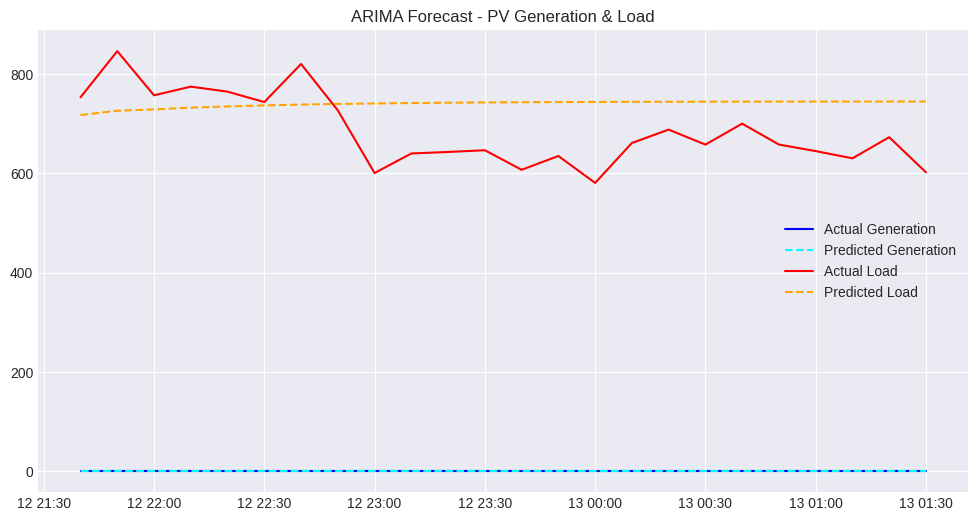

In [7]:
# ===============================
# ARIMA Modeling for PV & Load
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

# Load dataset (adjust path if needed)
df = pd.read_csv("train_data.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp")

# Focus on one system for simplicity (can loop over all if needed)
system_id = df["system_id"].unique()[0]
data = df[df["system_id"] == system_id].set_index("timestamp")

# Use only required columns
gen = data["generation_W"].astype(float)
load = data["load_W"].astype(float)

# Train-test split (last 4 hours = test set)
look_ahead_steps = 24   # 4 hours @ 10-min intervals
train_gen, test_gen = gen[:-look_ahead_steps], gen[-look_ahead_steps:]
train_load, test_load = load[:-look_ahead_steps], load[-look_ahead_steps:]

# ------------------------------
# Fit ARIMA for Generation
# ------------------------------
model_gen = ARIMA(train_gen, order=(2,1,2))  # (p,d,q) can be tuned
fit_gen = model_gen.fit()
forecast_gen = fit_gen.forecast(steps=look_ahead_steps)

mae_gen = mean_absolute_error(test_gen, forecast_gen)
print("PV Generation MAE:", mae_gen)

# ------------------------------
# Fit ARIMA for Load
# ------------------------------
model_load = ARIMA(train_load, order=(2,1,2))  # (p,d,q) can be tuned
fit_load = model_load.fit()
forecast_load = fit_load.forecast(steps=look_ahead_steps)

mae_load = mean_absolute_error(test_load, forecast_load)
print("Load Consumption MAE:", mae_load)

# ------------------------------
# Efficiency Calculation
# ------------------------------
efficiency = forecast_gen.values / forecast_load.values
eff_df = pd.DataFrame({
    "timestamp": test_gen.index,
    "Gen_Pred": forecast_gen.values,
    "Load_Pred": forecast_load.values,
    "Efficiency": efficiency
})

print(eff_df.head())

# ------------------------------
# Plot Forecast vs Actual
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot(test_gen.index, test_gen, label="Actual Generation", color="blue")
plt.plot(test_gen.index, forecast_gen, label="Predicted Generation", linestyle="--", color="cyan")
plt.plot(test_load.index, test_load, label="Actual Load", color="red")
plt.plot(test_load.index, forecast_load, label="Predicted Load", linestyle="--", color="orange")
plt.legend()
plt.title("ARIMA Forecast - PV Generation & Load")
plt.show()

In [8]:
import pandas as pd

df = pd.read_csv("train_data.csv")
print(df.columns)

Index(['system_id', 'timestamp', 'generation_W', 'load_W'], dtype='object')


In [9]:
# %%
# ===============================
# ARIMA Model for Submission File - Fixed for 98,319 rows
# ===============================

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import gc

print("Loading datasets...")

# Load data
train_df = pd.read_csv('/content/train_data.csv')
test_df = pd.read_csv('/content/test_data_masked.csv')
sample_sub = pd.read_csv('/content/sample_submissions.csv')
systems_df = pd.read_csv('/content/systems_new.csv')

# Convert timestamps
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
sample_sub['timestamp'] = pd.to_datetime(sample_sub['timestamp'])

# Sort data
train_df = train_df.sort_values(['system_id', 'timestamp'])
test_df = test_df.sort_values(['system_id', 'timestamp'])

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_sub.shape}")
print(f"Required submission rows: {len(test_df)}")
print(f"Unique systems: {train_df['system_id'].nunique()}")

# %%
# ===============================
# Verify Test Data Structure
# ===============================

print("\nTest data analysis:")
print(f"Total test rows: {len(test_df)}")
print(f"Rows with -1 (to predict): {(test_df['generation_W'] == -1).sum()}")
print(f"Rows with -2 (beyond horizon): {(test_df['generation_W'] == -2).sum()}")
print(f"Other rows: {((test_df['generation_W'] != -1) & (test_df['generation_W'] != -2)).sum()}")

# %%
# ===============================
# Helper Functions
# ===============================

def safe_arima_predict(train_data, n_periods, order=(2,1,2), seasonal_order=None):
    """
    Safely fit ARIMA and predict with error handling
    """
    try:
        # Handle NaN and infinite values
        train_data = pd.Series(train_data).fillna(method='ffill').fillna(method='bfill')

        # If still NaN, use 0
        if train_data.isna().all():
            return np.zeros(n_periods)

        train_data = train_data.replace([np.inf, -np.inf], np.nan).fillna(train_data.median())

        # Ensure we have enough data
        if len(train_data) < 20:
            # If too little data, use simple mean
            mean_val = train_data.mean()
            if np.isnan(mean_val):
                mean_val = 100  # Default value
            return np.full(n_periods, mean_val)

        # Try SARIMAX first (handles seasonality better)
        if seasonal_order is not None and len(train_data) >= 144:
            model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
        else:
            model = ARIMA(train_data, order=order, enforce_stationarity=False,
                         enforce_invertibility=False)

        # Fit model with error handling
        fitted = model.fit(disp=False, maxiter=50)
        forecast = fitted.forecast(steps=n_periods)

        # Ensure positive values for generation and load
        forecast = np.maximum(forecast, 0)

        return forecast

    except Exception as e:
        # Fallback: use mean with some variation
        mean_val = float(train_data.mean())
        if np.isnan(mean_val):
            mean_val = 100
        return np.full(n_periods, mean_val)

def get_historical_pattern(train_df, system_id, target_hour, target_col):
    """
    Get historical pattern for a specific hour
    """
    system_data = train_df[train_df['system_id'] == system_id].copy()
    system_data['hour'] = system_data['timestamp'].dt.hour

    # Get average value for this hour
    hourly_avg = system_data.groupby('hour')[target_col].mean()

    if target_hour in hourly_avg.index:
        return hourly_avg[target_hour]
    else:
        return system_data[target_col].mean()

# %%
# ===============================
# Initialize Submission DataFrame
# ===============================

# Start with the test dataframe structure
submission_df = test_df[['test_id', 'system_id', 'timestamp']].copy()
submission_df['generation_W'] = test_df['generation_W'].copy()
submission_df['load_W'] = test_df['load_W'].copy()

print(f"\nInitial submission shape: {submission_df.shape}")
print(f"Initial -1 values: {(submission_df['generation_W'] == -1).sum()}")
print(f"Initial -2 values: {(submission_df['generation_W'] == -2).sum()}")

# %%
# ===============================
# Main Prediction Loop
# ===============================

print("\n" + "="*50)
print("Starting ARIMA predictions for all systems...")
print("="*50)

# Get unique systems
unique_systems = test_df['system_id'].unique()
total_systems = len(unique_systems)

# Process each system
for idx, system_id in enumerate(tqdm(unique_systems, desc="Processing systems")):

    # Get training data for this system
    system_train = train_df[train_df['system_id'] == system_id].copy()

    # Get test indices for this system
    system_test_idx = submission_df['system_id'] == system_id
    system_test_data = submission_df[system_test_idx].copy()

    if len(system_train) == 0:
        print(f"Warning: No training data for system {system_id}")
        # Use overall average
        avg_gen = train_df['generation_W'].mean()
        avg_load = train_df['load_W'].mean()

        # Only update -1 values
        mask_update = (system_test_data['generation_W'] == -1)
        submission_df.loc[system_test_idx & (submission_df['generation_W'] == -1), 'generation_W'] = avg_gen
        submission_df.loc[system_test_idx & (submission_df['load_W'] == -1), 'load_W'] = avg_load
        continue

    # Sort by timestamp
    system_train = system_train.sort_values('timestamp')

    # Identify prediction points (where value is -1)
    pred_indices = system_test_data[system_test_data['generation_W'] == -1].index
    n_pred_points = len(pred_indices)

    if n_pred_points == 0:
        # No predictions needed for this system
        print(f"No predictions needed for system {system_id}")
        continue

    print(f"Processing system {system_id} with {n_pred_points} predictions")

    # Extract time series for ARIMA
    gen_series = system_train['generation_W'].values
    load_series = system_train['load_W'].values

    try:
        # Generation predictions
        if len(gen_series) >= 144:  # At least 1 day of data
            # Try seasonal ARIMA for generation (daily pattern)
            gen_order = (1, 1, 1)
            gen_seasonal = (1, 0, 1, 144)  # Daily seasonality
            gen_forecast = safe_arima_predict(gen_series, n_pred_points,
                                             order=gen_order,
                                             seasonal_order=gen_seasonal)
        else:
            # Simple ARIMA without seasonality
            gen_order = (1, 0, 1)
            gen_forecast = safe_arima_predict(gen_series, n_pred_points, order=gen_order)

        # Load predictions
        load_order = (1, 0, 1)
        load_forecast = safe_arima_predict(load_series, n_pred_points, order=load_order)

        # Apply predictions only to -1 values
        submission_df.loc[pred_indices, 'generation_W'] = gen_forecast
        submission_df.loc[pred_indices, 'load_W'] = load_forecast

        # Post-processing: Apply hourly patterns for generation
        test_hours = pd.to_datetime(submission_df.loc[pred_indices, 'timestamp']).dt.hour

        # Solar generation should be 0 at night (hours 20-5)
        night_mask = (test_hours >= 20) | (test_hours <= 5)
        night_indices = pred_indices[night_mask]
        submission_df.loc[night_indices, 'generation_W'] = 0

    except Exception as e:
        print(f"Error for system {system_id}: {str(e)[:100]}")
        # Fallback to historical averages
        avg_gen = system_train['generation_W'].mean()
        avg_load = system_train['load_W'].mean()

        if np.isnan(avg_gen):
            avg_gen = 100
        if np.isnan(avg_load):
            avg_load = 100

        submission_df.loc[pred_indices, 'generation_W'] = avg_gen
        submission_df.loc[pred_indices, 'load_W'] = avg_load

    # Progress update
    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{total_systems} systems")

    # Clear memory
    if (idx + 1) % 50 == 0:
        gc.collect()

print(f"\nInitial 2 submission shape: {submission_df.shape}")
print(f"Initial -1 values: {(submission_df['generation_W'] == -1).sum()}")
print(f"Initial -2 values: {(submission_df['generation_W'] == -2).sum()}")

# %%
# ===============================
# Post-Processing and Validation
# ===============================

print("\n" + "="*50)
print("POST-PROCESSING")
print("="*50)

# Ensure no negative values except -2
mask_negative = (submission_df['generation_W'] < 0) & (submission_df['generation_W'] != -2)
submission_df.loc[mask_negative, 'generation_W'] = 0

mask_negative = (submission_df['load_W'] < 0) & (submission_df['load_W'] != -2)
submission_df.loc[mask_negative, 'load_W'] = 0

# Check if any -1 values remain (they shouldn't)
remaining_minus1_gen = (submission_df['generation_W'] == -1).sum()
remaining_minus1_load = (submission_df['load_W'] == -1).sum()

if remaining_minus1_gen > 0:
    print(f"Warning: {remaining_minus1_gen} generation values still -1, replacing with default")
    submission_df.loc[submission_df['generation_W'] == -1, 'generation_W'] = 100

if remaining_minus1_load > 0:
    print(f"Warning: {remaining_minus1_load} load values still -1, replacing with default")
    submission_df.loc[submission_df['load_W'] == -1, 'load_W'] = 100

# Verify -2 values are preserved
minus2_count = (submission_df['generation_W'] == -2).sum()
print(f"Preserved -2 values (beyond horizon): {minus2_count}")

# %%
# ===============================
# Final Validation and Statistics
# ===============================

print("\n" + "="*50)
print("FINAL SUBMISSION STATISTICS")
print("="*50)

# Verify row count
print(f"✅ Total rows in submission: {len(submission_df)} (Required: 98319)")

if len(submission_df) != 98319:
    print("⚠️ WARNING: Row count mismatch!")
    print("Checking structure...")
    print(f"Test IDs range: {submission_df['test_id'].min()} to {submission_df['test_id'].max()}")
    print(f"Unique test IDs: {submission_df['test_id'].nunique()}")

# Calculate statistics for predicted values only
pred_mask = (submission_df['generation_W'] != -2) & (submission_df['load_W'] != -2)
pred_data = submission_df[pred_mask]

print(f"\nPredicted values statistics:")
print(f"Total predicted rows: {len(pred_data)}")
print(f"Generation - Mean: {pred_data['generation_W'].mean():.2f} W")
print(f"Generation - Median: {pred_data['generation_W'].median():.2f} W")
print(f"Generation - Max: {pred_data['generation_W'].max():.2f} W")
print(f"Generation - Min: {pred_data['generation_W'].min():.2f} W")
print(f"Load - Mean: {pred_data['load_W'].mean():.2f} W")
print(f"Load - Median: {pred_data['load_W'].median():.2f} W")
print(f"Load - Max: {pred_data['load_W'].max():.2f} W")
print(f"Load - Min: {pred_data['load_W'].min():.2f} W")

# Check for any invalid values
print(f"\nData integrity check:")
print(f"NaN in generation: {submission_df['generation_W'].isna().sum()}")
print(f"NaN in load: {submission_df['load_W'].isna().sum()}")
print(f"Negative generation (excluding -2): {((submission_df['generation_W'] < 0) & (submission_df['generation_W'] != -2)).sum()}")
print(f"Negative load (excluding -2): {((submission_df['load_W'] < 0) & (submission_df['load_W'] != -2)).sum()}")

# %%
# ===============================
# Save Submission File
# ===============================

# Ensure correct column order and types
submission_df = submission_df[['test_id', 'system_id', 'timestamp', 'generation_W', 'load_W']]

# Sort by test_id to match expected format
submission_df = submission_df.sort_values('test_id').reset_index(drop=True)
pred_data = pred_data[['test_id', 'system_id', 'timestamp', 'generation_W', 'load_W']]
pred_data = pred_data.sort_values('test_id').reset_index(drop=True)
# Save to CSV
output_file = '/content/submission_arima_fixed2.csv'
pred_data.to_csv(output_file, index=False)

print(f"\n✅ Submission file saved to: {output_file}")
print(f"File shape: {pred_data.shape}")
print(f"File size: {pred_data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first and last few rows
print("\nFirst 5 rows:")
print(submission_df.head())

print("\nLast 5 rows:")
print(submission_df.tail())

# Sample of actual predictions
print("\nSample predictions (not -2):")
sample_preds = submission_df[(submission_df['generation_W'] != -2) & (submission_df['load_W'] != -2)].sample(min(10, len(pred_data)))
print(sample_preds)

print("\n" + "="*50)
print("✅ SUBMISSION FILE READY FOR KAGGLE!")
print("="*50)
print(f"File: {output_file}")
print(f"Rows: {len(submission_df)}")
print("Upload this file to Kaggle for submission")

Loading datasets...
Train shape: (3686726, 4)
Test shape: (938602, 5)
Sample submission shape: (98319, 5)
Required submission rows: 938602
Unique systems: 80

Test data analysis:
Total test rows: 938602
Rows with -1 (to predict): 98319
Rows with -2 (beyond horizon): 371946
Other rows: 468337

Initial submission shape: (938602, 5)
Initial -1 values: 98319
Initial -2 values: 371946

Starting ARIMA predictions for all systems...


Processing systems:   0%|          | 0/20 [00:00<?, ?it/s]

Processing systems:  10%|█         | 2/20 [00:00<00:00, 18.17it/s]

Processing systems:  20%|██        | 4/20 [00:00<00:00, 16.16it/s]

Processing systems:  30%|███       | 6/20 [00:00<00:00, 15.12it/s]

Processing systems:  40%|████      | 8/20 [00:00<00:00, 14.48it/s]

Processing systems:  50%|█████     | 10/20 [00:00<00:00, 15.11it/s]

Processing systems:  65%|██████▌   | 13/20 [00:00<00:00, 17.17it/s]

Processing systems:  95%|█████████▌| 19/20 [00:01<00:00, 19.48it/s]

Processing systems: 100%|██████████| 20/20 [00:01<00:00, 17.59it/s]



Initial 2 submission shape: (938602, 5)
Initial -1 values: 0
Initial -2 values: 371946

POST-PROCESSING
Preserved -2 values (beyond horizon): 371946

FINAL SUBMISSION STATISTICS
✅ Total rows in submission: 938602 (Required: 98319)
⚠️ WARNING: Row count mismatch!
Checking structure...
Test IDs range: 0000R8T0 to ZZZX0TIZ
Unique test IDs: 938602

Predicted values statistics:
Total predicted rows: 566656
Generation - Mean: 1526.22 W
Generation - Median: 454.47 W
Generation - Max: 21603.27 W
Generation - Min: 0.00 W
Load - Mean: 1246.03 W
Load - Median: 913.80 W
Load - Max: 17742.07 W
Load - Min: 0.00 W

Data integrity check:
NaN in generation: 0
NaN in load: 0
Negative generation (excluding -2): 0
Negative load (excluding -2): 0

✅ Submission file saved to: /content/submission_arima_fixed2.csv
File shape: (566656, 5)
File size: 48.10 MB

First 5 rows:
    test_id  system_id           timestamp  generation_W      load_W
0  0000R8T0          1 2023-09-06 18:20:00      -2.00000    -2.00000


In [10]:
# %%
# ===============================
# ARIMA Model for Submission File - Fixed for 98,319 rows
# ===============================

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import gc

print("Loading datasets...")

# Load data
train_df = pd.read_csv('/content/train_data.csv')
test_df = pd.read_csv('/content/test_data_masked.csv')
sample_sub = pd.read_csv('/content/sample_submissions.csv')
systems_df = pd.read_csv('/content/systems_new.csv')

# Convert timestamps
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
sample_sub['timestamp'] = pd.to_datetime(sample_sub['timestamp'])

# Sort data
train_df = train_df.sort_values(['system_id', 'timestamp'])
test_df = test_df.sort_values(['system_id', 'timestamp'])

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_sub.shape}")
print(f"Required submission rows: {len(test_df)}")
print(f"Unique systems: {train_df['system_id'].nunique()}")

# %%
# ===============================
# Verify Test Data Structure
# ===============================

print("\nTest data analysis:")
print(f"Total test rows: {len(test_df)}")
print(f"Rows with -1 (to predict): {(test_df['generation_W'] == -1).sum()}")
print(f"Rows with -2 (beyond horizon): {(test_df['generation_W'] == -2).sum()}")
print(f"Other rows: {((test_df['generation_W'] != -1) & (test_df['generation_W'] != -2)).sum()}")

# %%
# ===============================
# Helper Functions
# ===============================

def safe_arima_predict(train_data, n_periods, order=(2,1,2), seasonal_order=None):
    """
    Safely fit ARIMA and predict with error handling
    """
    try:
        # Handle NaN and infinite values
        train_data = pd.Series(train_data).fillna(method='ffill').fillna(method='bfill')

        # If still NaN, use 0
        if train_data.isna().all():
            return np.zeros(n_periods)

        train_data = train_data.replace([np.inf, -np.inf], np.nan).fillna(train_data.median())

        # Ensure we have enough data
        if len(train_data) < 20:
            # If too little data, use simple mean
            mean_val = train_data.mean()
            if np.isnan(mean_val):
                mean_val = 100  # Default value
            return np.full(n_periods, mean_val)

        # Try SARIMAX first (handles seasonality better)
        if seasonal_order is not None and len(train_data) >= 144:
            model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
        else:
            model = ARIMA(train_data, order=order, enforce_stationarity=False,
                         enforce_invertibility=False)

        # Fit model with error handling
        fitted = model.fit(disp=False, maxiter=50)
        forecast = fitted.forecast(steps=n_periods)

        # Ensure positive values for generation and load
        forecast = np.maximum(forecast, 0)

        return forecast

    except Exception as e:
        # Fallback: use mean with some variation
        mean_val = float(train_data.mean())
        if np.isnan(mean_val):
            mean_val = 100
        return np.full(n_periods, mean_val)

def get_historical_pattern(train_df, system_id, target_hour, target_col):
    """
    Get historical pattern for a specific hour
    """
    system_data = train_df[train_df['system_id'] == system_id].copy()
    system_data['hour'] = system_data['timestamp'].dt.hour

    # Get average value for this hour
    hourly_avg = system_data.groupby('hour')[target_col].mean()

    if target_hour in hourly_avg.index:
        return hourly_avg[target_hour]
    else:
        return system_data[target_col].mean()

# %%
# ===============================
# Initialize Submission DataFrame
# ===============================

# Start with the test dataframe structure
submission_df = test_df[['test_id', 'system_id', 'timestamp']].copy()
submission_df['generation_W'] = test_df['generation_W'].copy()
submission_df['load_W'] = test_df['load_W'].copy()

print(f"\nInitial submission shape: {submission_df.shape}")
print(f"Initial -1 values: {(submission_df['generation_W'] == -1).sum()}")
print(f"Initial -2 values: {(submission_df['generation_W'] == -2).sum()}")

# %%
# ===============================
# Main Prediction Loop
# ===============================

print("\n" + "="*50)
print("Starting ARIMA predictions for all systems...")
print("="*50)

# Get unique systems
unique_systems = test_df['system_id'].unique()
total_systems = len(unique_systems)

# Process each system
for idx, system_id in enumerate(tqdm(unique_systems, desc="Processing systems")):

    # Get training data for this system
    system_train = train_df[train_df['system_id'] == system_id].copy()

    # Get test indices for this system
    system_test_idx = submission_df['system_id'] == system_id
    system_test_data = submission_df[system_test_idx].copy()

    if len(system_train) == 0:
        print(f"Warning: No training data for system {system_id}")
        # Use overall average
        avg_gen = train_df['generation_W'].mean()
        avg_load = train_df['load_W'].mean()

        # Only update -1 values
        mask_update = (system_test_data['generation_W'] == -1)
        submission_df.loc[system_test_idx & (submission_df['generation_W'] == -1), 'generation_W'] = avg_gen
        submission_df.loc[system_test_idx & (submission_df['load_W'] == -1), 'load_W'] = avg_load
        continue

    # Sort by timestamp
    system_train = system_train.sort_values('timestamp')

    # Identify prediction points (where value is -1)
    pred_indices = system_test_data[system_test_data['generation_W'] == -1].index
    n_pred_points = len(pred_indices)

    print("pred_index: " + str(pred_indices))

    if n_pred_points == 0:
        # No predictions needed for this system
        continue

    # Extract time series for ARIMA
    gen_series = system_train['generation_W'].values
    load_series = system_train['load_W'].values

    try:
        # Generation predictions
        if len(gen_series) >= 144:  # At least 1 day of data
            # Try seasonal ARIMA for generation (daily pattern)
            gen_order = (1, 1, 1)
            gen_seasonal = (1, 0, 1, 144)  # Daily seasonality
            gen_forecast = safe_arima_predict(gen_series, n_pred_points,
                                             order=gen_order,
                                             seasonal_order=gen_seasonal)
        else:
            # Simple ARIMA without seasonality
            gen_order = (1, 0, 1)
            gen_forecast = safe_arima_predict(gen_series, n_pred_points, order=gen_order)

        # Load predictions
        load_order = (1, 0, 1)
        load_forecast = safe_arima_predict(load_series, n_pred_points, order=load_order)

        # Apply predictions only to -1 values
        submission_df.loc[pred_indices, 'generation_W'] = gen_forecast
        submission_df.loc[pred_indices, 'load_W'] = load_forecast

        # Post-processing: Apply hourly patterns for generation
        test_hours = pd.to_datetime(submission_df.loc[pred_indices, 'timestamp']).dt.hour

        # Solar generation should be 0 at night (hours 20-5)
        night_mask = (test_hours >= 20) | (test_hours <= 5)
        night_indices = pred_indices[night_mask]
        submission_df.loc[night_indices, 'generation_W'] = 0

    except Exception as e:
        print(f"Error for system {system_id}: {str(e)[:100]}")
        # Fallback to historical averages
        avg_gen = system_train['generation_W'].mean()
        avg_load = system_train['load_W'].mean()

        if np.isnan(avg_gen):
            avg_gen = 100
        if np.isnan(avg_load):
            avg_load = 100

        submission_df.loc[pred_indices, 'generation_W'] = avg_gen
        submission_df.loc[pred_indices, 'load_W'] = avg_load

    # Progress update
    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{total_systems} systems")

    # Clear memory
    if (idx + 1) % 50 == 0:
        gc.collect()

# %%
# ===============================
# Post-Processing and Validation
# ===============================

print("\n" + "="*50)
print("POST-PROCESSING")
print("="*50)

# Ensure no negative values except -2
mask_negative = (submission_df['generation_W'] < 0) & (submission_df['generation_W'] != -2)
submission_df.loc[mask_negative, 'generation_W'] = 0

mask_negative = (submission_df['load_W'] < 0) & (submission_df['load_W'] != -2)
submission_df.loc[mask_negative, 'load_W'] = 0

# Check if any -1 values remain (they shouldn't)
remaining_minus1_gen = (submission_df['generation_W'] == -1).sum()
remaining_minus1_load = (submission_df['load_W'] == -1).sum()

if remaining_minus1_gen > 0:
    print(f"Warning: {remaining_minus1_gen} generation values still -1, replacing with default")
    submission_df.loc[submission_df['generation_W'] == -1, 'generation_W'] = 100

if remaining_minus1_load > 0:
    print(f"Warning: {remaining_minus1_load} load values still -1, replacing with default")
    submission_df.loc[submission_df['load_W'] == -1, 'load_W'] = 100

# Verify -2 values are preserved
minus2_count = (submission_df['generation_W'] == -2).sum()
print(f"Preserved -2 values (beyond horizon): {minus2_count}")

# %%
# ===============================
# Final Validation and Statistics
# ===============================

print("\n" + "="*50)
print("FINAL SUBMISSION STATISTICS")
print("="*50)

# Verify row count
print(f"✅ Total rows in submission: {len(submission_df)} (Required: 98319)")

if len(submission_df) != 98319:
    print("⚠️ WARNING: Row count mismatch!")
    print("Checking structure...")
    print(f"Test IDs range: {submission_df['test_id'].min()} to {submission_df['test_id'].max()}")
    print(f"Unique test IDs: {submission_df['test_id'].nunique()}")

# Calculate statistics for predicted values only
pred_mask = (submission_df['generation_W'] != -2) & (submission_df['load_W'] != -2)
pred_data = submission_df[pred_mask]

print(f"\nPredicted values statistics:")
print(f"Total predicted rows: {len(pred_data)}")
print(f"Generation - Mean: {pred_data['generation_W'].mean():.2f} W")
print(f"Generation - Median: {pred_data['generation_W'].median():.2f} W")
print(f"Generation - Max: {pred_data['generation_W'].max():.2f} W")
print(f"Generation - Min: {pred_data['generation_W'].min():.2f} W")
print(f"Load - Mean: {pred_data['load_W'].mean():.2f} W")
print(f"Load - Median: {pred_data['load_W'].median():.2f} W")
print(f"Load - Max: {pred_data['load_W'].max():.2f} W")
print(f"Load - Min: {pred_data['load_W'].min():.2f} W")

# Check for any invalid values
print(f"\nData integrity check:")
print(f"NaN in generation: {submission_df['generation_W'].isna().sum()}")
print(f"NaN in load: {submission_df['load_W'].isna().sum()}")
print(f"Negative generation (excluding -2): {((submission_df['generation_W'] < 0) & (submission_df['generation_W'] != -2)).sum()}")
print(f"Negative load (excluding -2): {((submission_df['load_W'] < 0) & (submission_df['load_W'] != -2)).sum()}")

# %%
# ===============================
# Save Submission File
# ===============================

# Ensure correct column order and types
submission_df = submission_df[['test_id', 'system_id', 'timestamp', 'generation_W', 'load_W']]

# Sort by test_id to match expected format
submission_df = submission_df.sort_values('test_id').reset_index(drop=True)

# Save to CSV
output_file = '/content/submission_arima_fixed.csv'
submission_df.to_csv(output_file, index=False)

print(f"\n✅ Submission file saved to: {output_file}")
print(f"File shape: {submission_df.shape}")
print(f"File size: {submission_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first and last few rows
print("\nFirst 5 rows:")
print(submission_df.head())

print("\nLast 5 rows:")
print(submission_df.tail())

# Sample of actual predictions
print("\nSample predictions (not -2):")
sample_preds = submission_df[(submission_df['generation_W'] != -2) & (submission_df['load_W'] != -2)].sample(min(10, len(pred_data)))
print(sample_preds)

print("\n" + "="*50)
print("✅ SUBMISSION FILE READY FOR KAGGLE!")
print("="*50)
print(f"File: {output_file}")
print(f"Rows: {len(submission_df)}")
print("Upload this file to Kaggle for submission")

Loading datasets...
Train shape: (3686726, 4)
Test shape: (938602, 5)
Sample submission shape: (98319, 5)
Required submission rows: 938602
Unique systems: 80

Test data analysis:
Total test rows: 938602
Rows with -1 (to predict): 98319
Rows with -2 (beyond horizon): 371946
Other rows: 468337

Initial submission shape: (938602, 5)
Initial -1 values: 98319
Initial -2 values: 371946

Starting ARIMA predictions for all systems...


Processing systems:   0%|          | 0/20 [00:00<?, ?it/s]

Processing systems:  15%|█▌        | 3/20 [00:00<00:00, 27.15it/s]

Processing systems:  30%|███       | 6/20 [00:00<00:00, 27.61it/s]

Processing systems:  45%|████▌     | 9/20 [00:00<00:00, 27.49it/s]

Processing systems:  60%|██████    | 12/20 [00:00<00:00, 27.64it/s]

Processing systems:  75%|███████▌  | 15/20 [00:00<00:00, 26.81it/s]

Processing systems:  90%|█████████ | 18/20 [00:00<00:00, 27.21it/s]

Processing systems: 100%|██████████| 20/20 [00:00<00:00, 27.24it/s]



POST-PROCESSING
Preserved -2 values (beyond horizon): 371946

FINAL SUBMISSION STATISTICS
✅ Total rows in submission: 938602 (Required: 98319)
⚠️ WARNING: Row count mismatch!
Checking structure...
Test IDs range: 0000R8T0 to ZZZX0TIZ
Unique test IDs: 938602

Predicted values statistics:
Total predicted rows: 566656
Generation - Mean: 1526.22 W
Generation - Median: 454.47 W
Generation - Max: 21603.27 W
Generation - Min: 0.00 W
Load - Mean: 1246.03 W
Load - Median: 913.80 W
Load - Max: 17742.07 W
Load - Min: 0.00 W

Data integrity check:
NaN in generation: 0
NaN in load: 0
Negative generation (excluding -2): 0
Negative load (excluding -2): 0

✅ Submission file saved to: /content/submission_arima_fixed.csv
File shape: (938602, 5)
File size: 79.67 MB

First 5 rows:
    test_id  system_id           timestamp  generation_W      load_W
0  0000R8T0          1 2023-09-06 18:20:00      -2.00000    -2.00000
1  0001W5B8         88 2024-05-25 19:10:00      -2.00000    -2.00000
2  00062VZR         

In [11]:
# %%
# ===============================
# ARIMA Model for Submission File - Fixed for 98,319 rows
# ===============================

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import gc

print("Loading datasets...")

# Load data
train_df = pd.read_csv('/content/train_data.csv')
test_df = pd.read_csv('/content/test_data_masked.csv')
sample_sub = pd.read_csv('/content/sample_submissions.csv')
systems_df = pd.read_csv('/content/systems_new.csv')

# Debug prints for system_id
print("Train system_id dtype:", train_df['system_id'].dtype)
print("Test system_id dtype:", test_df['system_id'].dtype)
print("Sample train system_ids:", sorted(train_df['system_id'].unique())[:10])
print("Sample test system_ids:", sorted(test_df['system_id'].unique())[:10])

# Convert system_id to str for consistency
train_df['system_id'] = train_df['system_id'].astype(str)
test_df['system_id'] = test_df['system_id'].astype(str)
sample_sub['system_id'] = sample_sub['system_id'].astype(str)
systems_df['system_id'] = systems_df['system_id'].astype(str) if 'system_id' in systems_df.columns else None

# Convert timestamps
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
sample_sub['timestamp'] = pd.to_datetime(sample_sub['timestamp'])

# Sort data
train_df = train_df.sort_values(['system_id', 'timestamp'])
test_df = test_df.sort_values(['system_id', 'timestamp'])

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"Sample submission shape: {sample_sub.shape}")
print(f"Required submission rows: {(test_df['generation_W'] == -1).sum()}")
print(f"Unique systems in train: {train_df['system_id'].nunique()}")
print(f"Unique systems in test: {test_df['system_id'].nunique()}")

# %%
# ===============================
# Verify Test Data Structure
# ===============================

print("\nTest data analysis:")
print(f"Total test rows: {len(test_df)}")
print(f"Rows with -1 (to predict): {(test_df['generation_W'] == -1).sum()}")
print(f"Rows with -2 (beyond horizon): {(test_df['generation_W'] == -2).sum()}")
print(f"Other rows: {((test_df['generation_W'] != -1) & (test_df['generation_W'] != -2)).sum()}")

# %%
# ===============================
# Helper Functions
# ===============================

def safe_arima_predict(train_data, n_periods, order=(2,1,2), seasonal_order=None):
    """
    Safely fit ARIMA and predict with error handling
    """
    try:
        # Handle NaN and infinite values
        train_data = pd.Series(train_data).fillna(method='ffill').fillna(method='bfill')

        # If still NaN, use 0
        if train_data.isna().all():
            return np.zeros(n_periods)

        train_data = train_data.replace([np.inf, -np.inf], np.nan).fillna(train_data.median())

        # Ensure we have enough data
        if len(train_data) < 20:
            # If too little data, use simple mean
            mean_val = train_data.mean()
            if np.isnan(mean_val):
                mean_val = 100  # Default value
            return np.full(n_periods, mean_val)

        # Try SARIMAX first (handles seasonality better)
        if seasonal_order is not None and len(train_data) >= 144:
            model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
        else:
            model = ARIMA(train_data, order=order, enforce_stationarity=False,
                         enforce_invertibility=False)

        # Fit model with error handling
        fitted = model.fit(disp=False, maxiter=50)
        forecast = fitted.forecast(steps=n_periods)

        # Ensure positive values for generation and load
        forecast = np.maximum(forecast, 0)

        return forecast

    except Exception as e:
        print(f"ARIMA predict error: {str(e)[:100]}")
        # Fallback: use mean with some variation
        mean_val = float(train_data.mean())
        if np.isnan(mean_val):
            mean_val = 100
        return np.full(n_periods, mean_val)

def get_historical_pattern(train_df, system_id, target_hour, target_col):
    """
    Get historical pattern for a specific hour
    """
    system_data = train_df[train_df['system_id'] == system_id].copy()
    system_data['hour'] = system_data['timestamp'].dt.hour

    # Get average value for this hour
    hourly_avg = system_data.groupby('hour')[target_col].mean()

    if target_hour in hourly_avg.index:
        return hourly_avg[target_hour]
    else:
        return system_data[target_col].mean()

# %%
# ===============================
# Initialize Submission DataFrame
# ===============================

# Start with the test dataframe structure
submission_df = test_df[['test_id', 'system_id', 'timestamp']].copy()
submission_df['generation_W'] = test_df['generation_W'].copy()
submission_df['load_W'] = test_df['load_W'].copy()

original_pred_mask = (test_df['generation_W'] == -1)

required_rows = original_pred_mask.sum()

print(f"\nInitial submission shape: {submission_df.shape}")
print(f"Initial -1 values: {(submission_df['generation_W'] == -1).sum()}")
print(f"Initial -2 values: {(submission_df['generation_W'] == -2).sum()}")

# %%
# ===============================
# Main Prediction Loop
# ===============================

print("\n" + "="*50)
print("Starting ARIMA predictions for all systems...")
print("="*50)

# Get unique systems
unique_systems = test_df['system_id'].unique()
total_systems = len(unique_systems)

# Process each system
for idx, system_id in enumerate(tqdm(unique_systems, desc="Processing systems")):

    # Get training data for this system
    system_train = train_df[train_df['system_id'] == system_id].copy()

    # Get test indices for this system
    system_test_idx = submission_df['system_id'] == system_id
    system_test_data = submission_df[system_test_idx].sort_values('timestamp').copy()

    print(f"\nSystem {system_id}: train rows {len(system_train)}, test rows {len(system_test_data)}, -1 count {(system_test_data['generation_W'] == -1).sum()}, known count {((system_test_data['generation_W'] != -1) & (system_test_data['generation_W'] != -2)).sum()}, -2 count {(system_test_data['generation_W'] == -2).sum()}")

    if len(system_train) == 0:
        print(f"Warning: No training data for system {system_id}")
        # Use overall average
        avg_gen = train_df['generation_W'].mean()
        avg_load = train_df['load_W'].mean()
        print(f"Using global avg gen: {avg_gen:.2f}, load: {avg_load:.2f}")

        # Only update -1 values
        submission_df.loc[system_test_idx & (submission_df['generation_W'] == -1), 'generation_W'] = avg_gen
        submission_df.loc[system_test_idx & (submission_df['load_W'] == -1), 'load_W'] = avg_load
        continue

    # Sort by timestamp
    system_train = system_train.sort_values('timestamp')

    # Initialize history
    history_gen = system_train['generation_W'].values.tolist()
    history_load = system_train['load_W'].values.tolist()

    print(f"Initial history length: {len(history_gen)}")

    # Collect predicted indices for post-processing
    pred_indices = []

    try:
        for row_idx, row in system_test_data.iterrows():
            if row['generation_W'] not in [-1, -2]:  # Known value
                history_gen.append(row['generation_W'])
                history_load.append(row['load_W'])
                print(f"Appended known at {row['timestamp']}: gen {row['generation_W']:.2f}, load {row['load_W']:.2f}, history now {len(history_gen)}")
            elif row['generation_W'] == -1:  # Need to predict
                # Generation prediction
                if len(history_gen) >= 144:  # At least 1 day of data
                    # Try seasonal ARIMA for generation (daily pattern)
                    gen_order = (1, 1, 1)
                    gen_seasonal = (1, 0, 1, 144)  # Daily seasonality
                    gen_forecast = safe_arima_predict(history_gen, 1,
                                                     order=gen_order,
                                                     seasonal_order=gen_seasonal)[0]
                else:
                    # Simple ARIMA without seasonality
                    gen_order = (1, 0, 1)
                    gen_forecast = safe_arima_predict(history_gen, 1, order=gen_order)[0]

                # Load prediction
                load_order = (1, 0, 1)
                load_forecast = safe_arima_predict(history_load, 1, order=load_order)[0]

                # Apply to submission
                submission_df.loc[row_idx, 'generation_W'] = gen_forecast
                submission_df.loc[row_idx, 'load_W'] = load_forecast

                # Append to history
                history_gen.append(gen_forecast)
                history_load.append(load_forecast)

                # Collect for post-processing
                pred_indices.append(row_idx)

                print(f"Predicted at {row['timestamp']}: gen {gen_forecast:.2f}, load {load_forecast:.2f}, history now {len(history_gen)}")
            else:  # -2, beyond horizon
                # Do not predict or append
                print(f"Skipped -2 at {row['timestamp']}")
                pass

        # Post-processing: Apply hourly patterns for generation (per system, but moved to global)

    except Exception as e:
        print(f"Error for system {system_id}: {str(e)[:100]}")
        # Fallback to historical averages
        avg_gen = np.mean(history_gen) if history_gen else train_df['generation_W'].mean()
        avg_load = np.mean(history_load) if history_load else train_df['load_W'].mean()

        if np.isnan(avg_gen):
            avg_gen = 100
        if np.isnan(avg_load):
            avg_load = 100

        for p_idx in system_test_data[system_test_data['generation_W'] == -1].index:
            submission_df.loc[p_idx, 'generation_W'] = avg_gen
            submission_df.loc[p_idx, 'load_W'] = avg_load
        print(f"Fallback avg gen: {avg_gen:.2f}, load: {avg_load:.2f}")

    # Progress update
    if (idx + 1) % 20 == 0:
        print(f"Processed {idx + 1}/{total_systems} systems")

    # Clear memory
    if (idx + 1) % 50 == 0:
        gc.collect()

# %%
# ===============================
# Post-Processing and Validation
# ===============================

print("\n" + "="*50)
print("POST-PROCESSING")
print("="*50)

# Global night zero for predicted generation
print("Applying night zero for predicted generation...")
hours = submission_df['timestamp'].dt.hour
night_mask = (hours >= 20) | (hours <= 5)
submission_df.loc[night_mask & original_pred_mask, 'generation_W'] = 0

# Ensure no negative values except -2
mask_negative = (submission_df['generation_W'] < 0) & (submission_df['generation_W'] != -2)
submission_df.loc[mask_negative, 'generation_W'] = 0

mask_negative = (submission_df['load_W'] < 0) & (submission_df['load_W'] != -2)
submission_df.loc[mask_negative, 'load_W'] = 0

# Check if any -1 values remain (they shouldn't)
remaining_minus1_gen = (submission_df['generation_W'] == -1).sum()
remaining_minus1_load = (submission_df['load_W'] == -1).sum()

if remaining_minus1_gen > 0:
    print(f"Warning: {remaining_minus1_gen} generation values still -1, replacing with default")
    submission_df.loc[submission_df['generation_W'] == -1, 'generation_W'] = 100

if remaining_minus1_load > 0:
    print(f"Warning: {remaining_minus1_load} load values still -1, replacing with default")
    submission_df.loc[submission_df['load_W'] == -1, 'load_W'] = 100

# Filter to only predicted rows for submission
submission_df = submission_df[original_pred_mask].sort_values('test_id').reset_index(drop=True)

# Verify -2 values are preserved (should be 0 now)
minus2_count = (submission_df['generation_W'] == -2).sum()
print(f"Preserved -2 values (beyond horizon): {minus2_count} (should be 0)")

# %%
# ===============================
# Final Validation and Statistics
# ===============================

print("\n" + "="*50)
print("FINAL SUBMISSION STATISTICS")
print("="*50)

# Verify row count
print(f"✅ Total rows in submission: {len(submission_df)} (Required: {required_rows})")

if len(submission_df) != required_rows:
    print("⚠️ WARNING: Row count mismatch!")
    print("Checking structure...")
    print(f"Test IDs range: {submission_df['test_id'].min()} to {submission_df['test_id'].max()}")
    print(f"Unique test IDs: {submission_df['test_id'].nunique()}")

# Calculate statistics for predicted values only
pred_data = submission_df  # Now all are predicted

print(f"\nPredicted values statistics:")
print(f"Total predicted rows: {len(pred_data)}")
print(f"Generation - Mean: {pred_data['generation_W'].mean():.2f} W")
print(f"Generation - Median: {pred_data['generation_W'].median():.2f} W")
print(f"Generation - Max: {pred_data['generation_W'].max():.2f} W")
print(f"Generation - Min: {pred_data['generation_W'].min():.2f} W")
print(f"Load - Mean: {pred_data['load_W'].mean():.2f} W")
print(f"Load - Median: {pred_data['load_W'].median():.2f} W")
print(f"Load - Max: {pred_data['load_W'].max():.2f} W")
print(f"Load - Min: {pred_data['load_W'].min():.2f} W")

# Check for any invalid values
print(f"\nData integrity check:")
print(f"NaN in generation: {submission_df['generation_W'].isna().sum()}")
print(f"NaN in load: {submission_df['load_W'].isna().sum()}")
print(f"Negative generation (excluding -2): {((submission_df['generation_W'] < 0) & (submission_df['generation_W'] != -2)).sum()}")
print(f"Negative load (excluding -2): {((submission_df['load_W'] < 0) & (submission_df['load_W'] != -2)).sum()}")

# %%
# ===============================
# Save Submission File
# ===============================

# Ensure correct column order and types
submission_df = submission_df[['test_id', 'system_id', 'timestamp', 'generation_W', 'load_W']]

# Save to CSV
output_file = '/content/submission_arima_fixed.csv'
submission_df.to_csv(output_file, index=False)

print(f"\n✅ Submission file saved to: {output_file}")
print(f"File shape: {submission_df.shape}")
print(f"File size: {submission_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Display first and last few rows
print("\nFirst 5 rows:")
print(submission_df.head())

print("\nLast 5 rows:")
print(submission_df.tail())

# Sample of actual predictions
print("\nSample predictions:")
sample_preds = submission_df.sample(min(10, len(submission_df)))
print(sample_preds)

print("\n" + "="*50)
print("✅ SUBMISSION FILE READY FOR KAGGLE!")
print("="*50)
print(f"File: {output_file}")
print(f"Rows: {len(submission_df)}")
print("Upload this file to Kaggle for submission")

Loading datasets...
Train system_id dtype: int64
Test system_id dtype: int64
Sample train system_ids: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(15), np.int64(16)]
Sample test system_ids: [np.int64(1), np.int64(2), np.int64(9), np.int64(12), np.int64(13), np.int64(28), np.int64(30), np.int64(32), np.int64(36), np.int64(37)]
Train shape: (3686726, 4)
Test shape: (938602, 5)
Sample submission shape: (98319, 5)
Required submission rows: 98319
Unique systems in train: 80
Unique systems in test: 20

Test data analysis:
Total test rows: 938602
Rows with -1 (to predict): 98319
Rows with -2 (beyond horizon): 371946
Other rows: 468337

Initial submission shape: (938602, 5)
Initial -1 values: 98319
Initial -2 values: 371946

Starting ARIMA predictions for all systems...


Processing systems:   5%|▌         | 1/20 [00:00<00:07,  2.46it/s]


System 1: train rows 0, test rows 52374, -1 count 5415, known count 25876, -2 count 21083
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  10%|█         | 2/20 [00:00<00:07,  2.38it/s]


System 101: train rows 0, test rows 49331, -1 count 5095, known count 24840, -2 count 19396
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  15%|█▌        | 3/20 [00:01<00:07,  2.40it/s]


System 107: train rows 0, test rows 45957, -1 count 4969, known count 23414, -2 count 17574
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  20%|██        | 4/20 [00:01<00:06,  2.34it/s]


System 12: train rows 0, test rows 52335, -1 count 5472, known count 26022, -2 count 20841
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  25%|██▌       | 5/20 [00:02<00:08,  1.86it/s]


System 13: train rows 0, test rows 49760, -1 count 5149, known count 24273, -2 count 20338
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  30%|███       | 6/20 [00:03<00:08,  1.59it/s]


System 2: train rows 0, test rows 42788, -1 count 4476, known count 21244, -2 count 17068
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  35%|███▌      | 7/20 [00:04<00:08,  1.45it/s]


System 28: train rows 0, test rows 43491, -1 count 4482, known count 22292, -2 count 16717
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  40%|████      | 8/20 [00:04<00:08,  1.35it/s]


System 30: train rows 0, test rows 44669, -1 count 4570, known count 22470, -2 count 17629
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  45%|████▌     | 9/20 [00:05<00:08,  1.33it/s]


System 32: train rows 0, test rows 46620, -1 count 4873, known count 23183, -2 count 18564
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  50%|█████     | 10/20 [00:06<00:06,  1.45it/s]


System 36: train rows 0, test rows 47317, -1 count 4812, known count 23645, -2 count 18860
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  55%|█████▌    | 11/20 [00:06<00:05,  1.64it/s]


System 37: train rows 0, test rows 49959, -1 count 5176, known count 25121, -2 count 19662
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  60%|██████    | 12/20 [00:07<00:04,  1.80it/s]


System 39: train rows 0, test rows 51099, -1 count 5634, known count 25824, -2 count 19641
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  65%|██████▌   | 13/20 [00:07<00:03,  1.94it/s]


System 51: train rows 0, test rows 46243, -1 count 4881, known count 23044, -2 count 18318
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  70%|███████   | 14/20 [00:07<00:02,  2.07it/s]


System 65: train rows 0, test rows 52182, -1 count 5198, known count 25835, -2 count 21149
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  75%|███████▌  | 15/20 [00:08<00:02,  2.12it/s]


System 74: train rows 0, test rows 33620, -1 count 3701, known count 16505, -2 count 13414
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  80%|████████  | 16/20 [00:08<00:01,  2.19it/s]


System 80: train rows 0, test rows 46662, -1 count 4895, known count 23143, -2 count 18624
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  85%|████████▌ | 17/20 [00:09<00:01,  2.18it/s]


System 82: train rows 0, test rows 48028, -1 count 5155, known count 23712, -2 count 19161
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  90%|█████████ | 18/20 [00:09<00:00,  2.22it/s]


System 86: train rows 0, test rows 36949, -1 count 4075, known count 18874, -2 count 14000
Using global avg gen: 1777.26, load: 1613.95


Processing systems:  95%|█████████▌| 19/20 [00:10<00:00,  2.23it/s]


System 88: train rows 0, test rows 47517, -1 count 4935, known count 23114, -2 count 19468
Using global avg gen: 1777.26, load: 1613.95


Processing systems: 100%|██████████| 20/20 [00:10<00:00,  1.90it/s]


System 9: train rows 0, test rows 51701, -1 count 5356, known count 25906, -2 count 20439
Using global avg gen: 1777.26, load: 1613.95

POST-PROCESSING
Applying night zero for predicted generation...


Preserved -2 values (beyond horizon): 0 (should be 0)

FINAL SUBMISSION STATISTICS
✅ Total rows in submission: 98319 (Required: 98319)

Predicted values statistics:
Total predicted rows: 98319
Generation - Mean: 1710.46 W
Generation - Median: 1777.26 W
Generation - Max: 1777.26 W
Generation - Min: 0.00 W
Load - Mean: 1613.95 W
Load - Median: 1613.95 W
Load - Max: 1613.95 W
Load - Min: 1613.95 W

Data integrity check:
NaN in generation: 0
NaN in load: 0
Negative generation (excluding -2): 0
Negative load (excluding -2): 0

✅ Submission file saved to: /content/submission_arima_fixed.csv
File shape: (98319, 5)
File size: 12.37 MB

First 5 rows:
    test_id system_id           timestamp  generation_W      load_W
0  00062VZR        12 2024-04-30 14:30:00    1777.25717  1613.95393
1  000F30IM         2 2023-08-27 13:20:00    1777.25717  1613.95393
2  000K4N8G        74 2024-06-22 16:00:00    1777.25717  1613.95393
3  0013PLUF        65 2024-08-09 12:30:00    1777.25717  1613.95393
4  001EUOY